# Criteo CTR Prediction EDA

In [1]:
# Imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

from pyspark.sql import SQLContext
from pyspark.sql import types
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

%matplotlib inline
plt.style.use('ggplot')

## From the Readme
Dataset construction:

The training dataset consists of a portion of Criteo's traffic over a period
of 7 days. Each row corresponds to a display ad served by Criteo and the first
column is indicates whether this ad has been clicked or not.
The positive (clicked) and negatives (non-clicked) examples have both been
subsampled (but at different rates) in order to reduce the dataset size.

There are 13 features taking integer values (mostly count features) and 26
categorical features. The values of the categorical features have been hashed
onto 32 bits for anonymization purposes. 
The semantic of these features is undisclosed. Some features may have missing values.

The rows are chronologically ordered.

The test set is computed in the same way as the training set but it 
corresponds to events on the day following the training period. 
The first column (label) has been removed.

====================================================

Format:

The columns are tab separeted with the following schema:
<label> <integer feature 1> ... <integer feature 13> <categorical feature 1> ... <categorical feature 26>

When a value is missing, the field is just empty.
There is no label field in the test set.


Pull the train set, take a random sample of 10,000 records, and load into a Pandas DataFrame for analysis.

In [12]:
train_RDD = sc.textFile("gs://w261-final-hoky/data/train.txt")
train_RDD.count()

45840617

In [13]:
sample = train_RDD.map(lambda x: x.split('\t')) \
                  .takeSample(False, 10000, seed=261)

In [14]:
df = pd.DataFrame.from_records(sample, columns=[x for x in range(14)]+list(map(chr, range(97, 123))))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,q,r,s,t,u,v,w,x,y,z
0,0,22,-1,26,0,0,0,22,6,0,...,27c07bd6,1f868fdd,f44bef3c,b1252a9d,98459119,ad3062eb,32c7478e,e18cf978,001f3601,7a1d43a0
1,0,,0,14,7,582312,,0,7,24,...,07c540c4,5aed7436,cd11c728,a458ea53,61f86188,,3a171ecb,b447f3b2,9d93af03,852e35dd
2,0,0,-1,,,4438,,,0,,...,e5ba7672,6acca89e,,,45130880,,32c7478e,488c9489,,
3,1,,4,8,8,8501,,0,29,29,...,776ce399,17a67eff,,,eb37e392,,32c7478e,6042edf0,,
4,0,9,0,18,1,11,1,117,4,185,...,27c07bd6,5bb2ec8e,064f1f80,a458ea53,118d9d51,ad3062eb,32c7478e,9dec18a0,f0f449dd,cb85773a


## NAs

In [17]:
for r in df.columns:
    col_na_count = (df[r]=="").sum()
    col_na_share = np.round((col_na_count/len(df))*100, 2)
    print('Column {:2}: {:4} NAs, {:.2f}% of total'.format(r, col_na_count, col_na_share))

Column  0:    0 NAs, 0.00% of total
Column  1: 4523 NAs, 45.23% of total
Column  2:    0 NAs, 0.00% of total
Column  3: 2100 NAs, 21.00% of total
Column  4: 2116 NAs, 21.16% of total
Column  5:  217 NAs, 2.17% of total
Column  6: 2205 NAs, 22.05% of total
Column  7:  400 NAs, 4.00% of total
Column  8:    1 NAs, 0.01% of total
Column  9:  400 NAs, 4.00% of total
Column 10: 4523 NAs, 45.23% of total
Column 11:  400 NAs, 4.00% of total
Column 12: 7593 NAs, 75.93% of total
Column 13: 2116 NAs, 21.16% of total
Column a :    0 NAs, 0.00% of total
Column b :    0 NAs, 0.00% of total
Column c :  343 NAs, 3.43% of total
Column d :  343 NAs, 3.43% of total
Column e :    0 NAs, 0.00% of total
Column f : 1191 NAs, 11.91% of total
Column g :    0 NAs, 0.00% of total
Column h :    0 NAs, 0.00% of total
Column i :    0 NAs, 0.00% of total
Column j :    0 NAs, 0.00% of total
Column k :    0 NAs, 0.00% of total
Column l :  343 NAs, 3.43% of total
Column m :    0 NAs, 0.00% of total
Column n :    0 NAs,

## Column 0 
The only column we know anything about.  1 = this ad was clicked, 0 = it wasn't.

In [18]:
col0 = df[0].astype(int)

In [19]:
(col0==1).sum()

2509

So ~25% of records were clicked.

In [21]:
df_c = pd.DataFrame(col0)

## Column 1

In [22]:
col1 = df[1].replace('', '-1').astype(int)
np.sort(col1.unique())

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  57,  59,  61,  63,  71,  76,  78,  79,  80,
        81,  83,  86,  88, 101, 106, 107, 112, 155, 255])

In [23]:
col1_notna = df[df[1] != ''][1].astype(int)
col1_notna.describe()

count    5477.000000
mean        3.484389
std         8.845644
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       255.000000
Name: 1, dtype: float64

(array([9.423e+03, 3.790e+02, 9.700e+01, 4.000e+01, 2.500e+01, 1.300e+01,
        6.000e+00, 2.000e+00, 8.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ -1.        ,   8.84615385,  18.69230769,  28.53846154,
         38.38461538,  48.23076923,  58.07692308,  67.92307692,
         77.76923077,  87.61538462,  97.46153846, 107.30769231,
        117.15384615, 127.        , 136.84615385, 146.69230769,
        156.53846154, 166.38461538, 176.23076923, 186.07692308,
        195.92307692, 205.76923077, 215.61538462, 225.46153846,
        235.30769231, 245.15384615, 255.        ]),
 <a list of 26 Patch objects>)

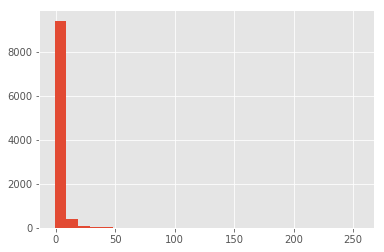

In [24]:
plt.hist(col1, bins=26)

(array([4523., 2294.,  979.,  577.,  313.,  256.,  164.,  146.,   98.,
          73.,   66.]),
 array([-1.        , -0.09090909,  0.81818182,  1.72727273,  2.63636364,
         3.54545455,  4.45454545,  5.36363636,  6.27272727,  7.18181818,
         8.09090909,  9.        ]),
 <a list of 11 Patch objects>)

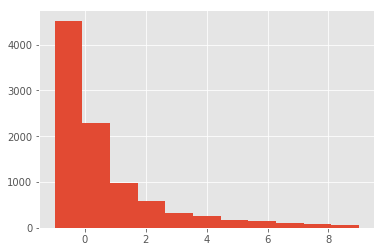

In [25]:
plt.hist(col1[col1<10], bins=11)

45% of the field is NAs, with the vast bulk of the rest small integers < 10, and about half of those are 0.

In [26]:
col0.corr(col1)

0.11192077805551848

In [27]:
col1_binary = df[1].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col1_binary)

0.1848936604328296

Not a lot of correlation with the target variable.

In [28]:
df_c[1] = col1

## Column 2: 

In [29]:
col2 = df[2].astype(int)
np.sort(col2.unique())

array([  -2,   -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,
          9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
         20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,
         31,   32,   33,   34,   35,   36,   37,   38,   39,   40,   41,
         42,   43,   44,   45,   46,   47,   48,   49,   50,   51,   52,
         53,   54,   55,   56,   57,   58,   59,   60,   61,   62,   63,
         64,   65,   66,   67,   68,   69,   70,   71,   72,   73,   74,
         75,   76,   77,   78,   79,   80,   81,   82,   83,   84,   85,
         86,   87,   88,   89,   90,   91,   92,   93,   94,   95,   96,
         97,   98,   99,  100,  101,  102,  103,  104,  105,  106,  107,
        108,  109,  110,  111,  112,  113,  114,  115,  116,  117,  118,
        119,  120,  121,  122,  123,  124,  125,  126,  127,  128,  129,
        130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140,
        141,  142,  143,  144,  145,  146,  147,  1

In [30]:
col2.describe()

count    10000.000000
mean       107.395000
std        400.237916
min         -2.000000
25%          0.000000
50%          3.000000
75%         37.000000
max       9319.000000
Name: 2, dtype: float64

(array([9.69e+03, 1.63e+02, 9.20e+01, 4.70e+01, 2.00e+00, 2.00e+00,
        2.00e+00, 1.00e+00, 0.00e+00, 1.00e+00]),
 array([-2.0000e+00,  9.3010e+02,  1.8622e+03,  2.7943e+03,  3.7264e+03,
         4.6585e+03,  5.5906e+03,  6.5227e+03,  7.4548e+03,  8.3869e+03,
         9.3190e+03]),
 <a list of 10 Patch objects>)

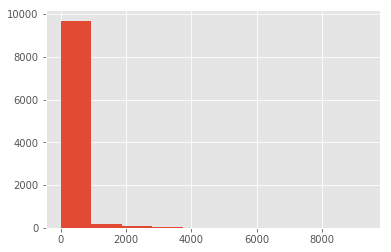

In [31]:
plt.hist(col2)

(array([9.69e+03, 1.63e+02, 9.20e+01, 4.70e+01, 2.00e+00, 2.00e+00,
        2.00e+00, 1.00e+00, 0.00e+00, 1.00e+00]),
 array([-2.0000e+00,  9.3010e+02,  1.8622e+03,  2.7943e+03,  3.7264e+03,
         4.6585e+03,  5.5906e+03,  6.5227e+03,  7.4548e+03,  8.3869e+03,
         9.3190e+03]),
 <a list of 10 Patch objects>)

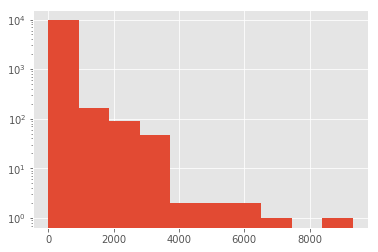

In [32]:
plt.hist(col2, log=True)

(array([   7., 1050., 1745., 1547.,  542.]),
 array([-2. , -1.2, -0.4,  0.4,  1.2,  2. ]),
 <a list of 5 Patch objects>)

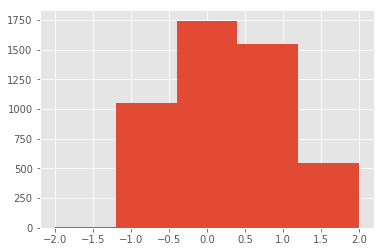

In [33]:
plt.hist(col2[col2<3], bins=5)

In [34]:
col2_binary = df[2].replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col2_binary)

-0.02232433955829875

In [35]:
col0.corr(col2)

0.04226053628601019

In [36]:
df_c[2] = col2

**Summary**: No NAs in this one.  Integers ranging from -2 to 9319, but huge positive skew - nearly all values are clustered around 0, but only ~17% actually ARE 0.  No meaningful correlation with the target column here.

## Column 3

In [37]:
col3 = df[3].replace('', '-1').astype(int)
np.sort(col3.unique())

array([   -1,     0,     1,     2,     3,     4,     5,     6,     7,
           8,     9,    10,    11,    12,    13,    14,    15,    16,
          17,    18,    19,    20,    21,    22,    23,    24,    25,
          26,    27,    28,    29,    30,    31,    32,    33,    34,
          35,    36,    37,    38,    39,    40,    41,    42,    43,
          44,    45,    46,    47,    48,    49,    50,    51,    52,
          53,    54,    55,    56,    57,    58,    59,    60,    61,
          62,    63,    64,    65,    66,    67,    68,    69,    70,
          71,    72,    73,    74,    75,    76,    77,    78,    79,
          80,    81,    82,    83,    84,    85,    86,    87,    88,
          89,    90,    91,    92,    93,    94,    95,    96,    97,
          98,    99,   100,   101,   102,   103,   104,   105,   106,
         107,   108,   109,   110,   111,   112,   113,   114,   115,
         116,   117,   118,   119,   120,   121,   123,   124,   125,
         126,   127,

In [38]:
col3_notna = df[df[3] != ''][3].astype(int)
col3_notna.describe()

count     7900.000000
mean        35.987975
std        638.417816
min          0.000000
25%          2.000000
50%          7.000000
75%         18.000000
max      33615.000000
Name: 3, dtype: float64

(array([9.995e+03, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([-1.00000e+00,  3.36060e+03,  6.72220e+03,  1.00838e+04,
         1.34454e+04,  1.68070e+04,  2.01686e+04,  2.35302e+04,
         2.68918e+04,  3.02534e+04,  3.36150e+04]),
 <a list of 10 Patch objects>)

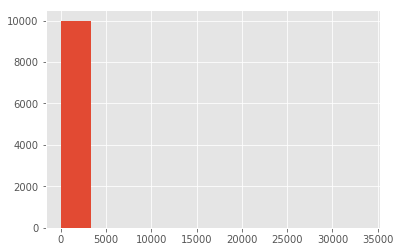

In [39]:
plt.hist(col3)

(array([9.995e+03, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([-1.00000e+00,  3.36060e+03,  6.72220e+03,  1.00838e+04,
         1.34454e+04,  1.68070e+04,  2.01686e+04,  2.35302e+04,
         2.68918e+04,  3.02534e+04,  3.36150e+04]),
 <a list of 10 Patch objects>)

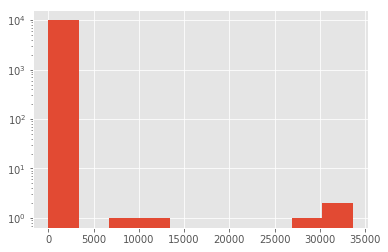

In [40]:
plt.hist(col3, log=True)

(array([2100.,   40., 1207.,  828.,  663.,  483.,  398.,  329.,  298.,
         231.,  240.,  181.,  154.,  194.,  150.,  131.]),
 array([-1.    , -0.0625,  0.875 ,  1.8125,  2.75  ,  3.6875,  4.625 ,
         5.5625,  6.5   ,  7.4375,  8.375 ,  9.3125, 10.25  , 11.1875,
        12.125 , 13.0625, 14.    ]),
 <a list of 16 Patch objects>)

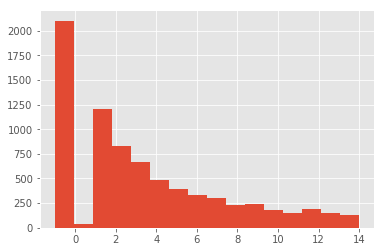

In [41]:
plt.hist(col3[col3<15], bins=16)

In [42]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col3_binary = df[3].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col3_binary)

-0.056283729892532074

In [43]:
col0.corr(col3)

0.01744024355631531

In [44]:
# For the records with very high values here, what does the target variable look like?
df_c[3] = col3
df_c[df_c[3]>1000]

,0,1,2,3
190,1,49,328,9032
343,1,10,18,10674
532,1,49,1,33615
1261,0,-1,1,2149
1405,0,0,29,1924
2139,0,1,0,29049
4802,1,41,0,31692
5183,0,-1,0,1252
5375,0,-1,1,1042
5667,1,3,1,1264


**Summary**: 31% NAs.  Integers ranging from 0 to 33615 with positive skew, but very few records actually at 0 and very few outliers above 1000, although these outliers appear to have a higher proportion of 1s in the target column.  Overall, however, low correlation with the target variable.

## Column 4

In [45]:
col4 = df[4].replace('', '-1').astype(int)
np.sort(col4.unique())

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  55,  59,  61,  63,  66,  68,  72,  74,  81,  86,  92,
       109, 188])

In [46]:
col4_notna = df[df[4] != ''][4].astype(int)
col4_notna.describe()

count    7884.000000
mean        7.361238
std         8.873512
min         0.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       188.000000
Name: 4, dtype: float64

(array([9.17e+03, 7.02e+02, 1.14e+02, 9.00e+00, 3.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([ -1. ,  17.9,  36.8,  55.7,  74.6,  93.5, 112.4, 131.3, 150.2,
        169.1, 188. ]),
 <a list of 10 Patch objects>)

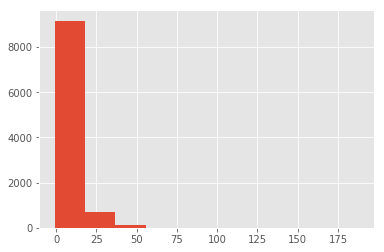

In [47]:
plt.hist(col4)

(array([9.17e+03, 7.02e+02, 1.14e+02, 9.00e+00, 3.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([ -1. ,  17.9,  36.8,  55.7,  74.6,  93.5, 112.4, 131.3, 150.2,
        169.1, 188. ]),
 <a list of 10 Patch objects>)

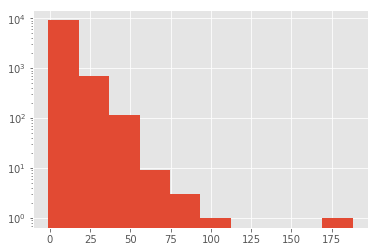

In [48]:
plt.hist(col4, log=True)

(array([2116.,  478., 1269.,  956.,  767.,  583.,  553.,  392.,  321.,
         271.,  253.,  233.,  196.,  167.,  143.,  149.,  136.,  104.,
          83.,  154.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19.]),
 <a list of 20 Patch objects>)

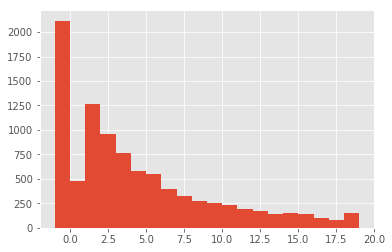

In [49]:
plt.hist(col4[col4<20], bins=20)

In [50]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col4_binary = df[4].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col4_binary)

-0.05692346021439246

In [51]:
col0.corr(col4)

-0.06426429245203326

In [52]:
df_c[4] = col4

**Summary**: 21% NAs.  Integers ranging from 0 to 188 with positive skew, but most records are > 0.  No correlation to target.

## Column 5

In [53]:
col5 = df[5].replace('', '-1').astype(int)
np.sort(col5.unique())

array([     -1,       0,       1, ..., 1293112, 1508903, 1517980])

In [54]:
col5_notna = df[df[5] != ''][5].astype(int)
col5_notna.describe()

count    9.783000e+03
mean     1.853427e+04
std      7.075676e+04
min      0.000000e+00
25%      3.120000e+02
50%      2.795000e+03
75%      1.007100e+04
max      1.517980e+06
Name: 5, dtype: float64

(array([9.75e+03, 1.33e+02, 5.30e+01, 3.40e+01, 1.30e+01, 7.00e+00,
        4.00e+00, 3.00e+00, 1.00e+00, 2.00e+00]),
 array([-1.0000000e+00,  1.5179710e+05,  3.0359520e+05,  4.5539330e+05,
         6.0719140e+05,  7.5898950e+05,  9.1078760e+05,  1.0625857e+06,
         1.2143838e+06,  1.3661819e+06,  1.5179800e+06]),
 <a list of 10 Patch objects>)

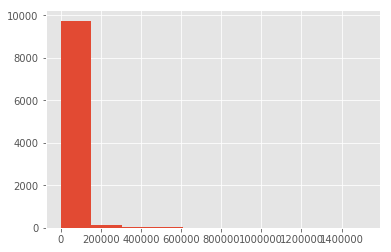

In [55]:
plt.hist(col5)

(array([9.75e+03, 1.33e+02, 5.30e+01, 3.40e+01, 1.30e+01, 7.00e+00,
        4.00e+00, 3.00e+00, 1.00e+00, 2.00e+00]),
 array([-1.0000000e+00,  1.5179710e+05,  3.0359520e+05,  4.5539330e+05,
         6.0719140e+05,  7.5898950e+05,  9.1078760e+05,  1.0625857e+06,
         1.2143838e+06,  1.3661819e+06,  1.5179800e+06]),
 <a list of 10 Patch objects>)

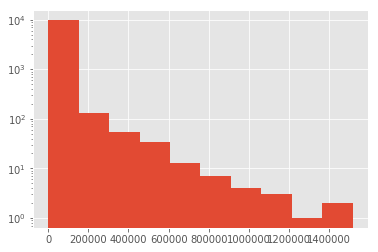

In [56]:
plt.hist(col5, log=True)

(array([217., 194., 242., 148.,   0., 125., 105.,   0.,  79.,  56.,   0.,
         64.,  46.,  46.,  46.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14.]),
 <a list of 15 Patch objects>)

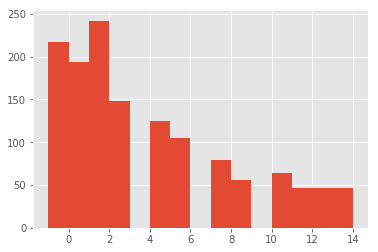

In [57]:
plt.hist(col5[col5<15], bins=15)

In [58]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col5_binary = df[5].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col5_binary)

-0.028908417758625425

In [59]:
col0.corr(col5)

-0.06791943209715695

In [60]:
df_c[5] = col5

**Summary**: 11% NAs.  Integers ranging from 0 to 1.5m with positive skew, but most records are > 0.  Low multiples of three are oddly scarce (ie, no 3, 6, 9, 15, but there are 12s).  No correlation to target.

## Column 6

In [61]:
col6 = df[6].replace('', '-1').astype(int)
np.sort(col6.unique())

array([   -1,     0,     1,     2,     3,     4,     5,     6,     7,
           8,     9,    10,    11,    12,    13,    14,    15,    16,
          17,    18,    19,    20,    21,    22,    23,    24,    25,
          26,    27,    28,    29,    30,    31,    32,    33,    34,
          35,    36,    37,    38,    39,    40,    41,    42,    43,
          44,    45,    46,    47,    48,    49,    50,    51,    52,
          53,    54,    55,    56,    57,    58,    59,    60,    61,
          62,    63,    64,    65,    66,    67,    68,    69,    70,
          71,    72,    73,    74,    75,    76,    77,    78,    79,
          80,    81,    82,    83,    84,    85,    86,    87,    88,
          89,    90,    91,    92,    93,    94,    95,    96,    97,
          98,    99,   100,   101,   102,   103,   104,   105,   106,
         107,   108,   109,   110,   111,   112,   113,   114,   115,
         116,   117,   118,   119,   120,   121,   122,   123,   124,
         125,   126,

In [62]:
col6_notna = df[df[6] != ''][6].astype(int)
col6_notna.describe()

count     7795.000000
mean       118.089929
std        321.927826
min          0.000000
25%          8.000000
50%         32.000000
75%        100.000000
max      10139.000000
Name: 6, dtype: float64

(array([9.87e+03, 1.03e+02, 1.60e+01, 3.00e+00, 3.00e+00, 3.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00]),
 array([-1.0000e+00,  1.0130e+03,  2.0270e+03,  3.0410e+03,  4.0550e+03,
         5.0690e+03,  6.0830e+03,  7.0970e+03,  8.1110e+03,  9.1250e+03,
         1.0139e+04]),
 <a list of 10 Patch objects>)

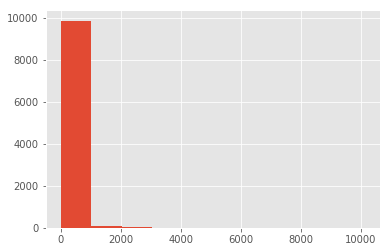

In [63]:
plt.hist(col6)

(array([9.87e+03, 1.03e+02, 1.60e+01, 3.00e+00, 3.00e+00, 3.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00]),
 array([-1.0000e+00,  1.0130e+03,  2.0270e+03,  3.0410e+03,  4.0550e+03,
         5.0690e+03,  6.0830e+03,  7.0970e+03,  8.1110e+03,  9.1250e+03,
         1.0139e+04]),
 <a list of 10 Patch objects>)

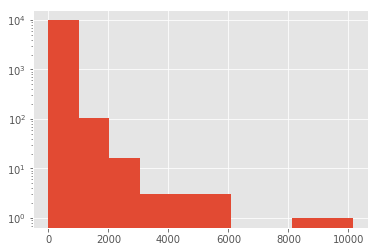

In [64]:
plt.hist(col6, log=True)

(array([2205.,  541.,  285.,  260.,  235.,  163.,  159.,  157.,  144.,
         237.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 10 Patch objects>)

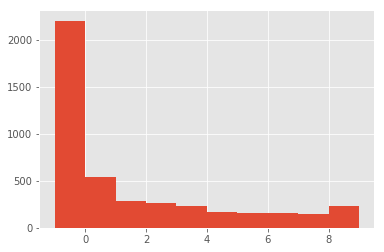

In [65]:
plt.hist(col6[col6<10], bins=10)

In [66]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col6_binary = df[6].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col6_binary)

0.060453356194159945

In [67]:
col0.corr(col6)

-0.07122072617700667

In [68]:
df_c[6] = col6

**Summary**: 22% NAs.  Integers ranging from 0 to 10,000 with a very long tail.  No correlation to target, though simply having a value is more positive correlation than using the value itself (though not large in real terms).

## Column 7

In [69]:
col7 = df[7].replace('', '-1').astype(int)
np.sort(col7.unique())

array([  -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48,   49,   50,   51,   52,   53,
         54,   55,   56,   57,   58,   59,   60,   61,   62,   63,   64,
         65,   66,   67,   68,   69,   70,   71,   72,   73,   74,   75,
         76,   77,   78,   79,   80,   81,   82,   83,   84,   85,   86,
         87,   88,   89,   90,   91,   92,   93,   94,   95,   96,   97,
         98,   99,  100,  101,  102,  103,  104,  105,  106,  107,  108,
        109,  110,  111,  112,  113,  114,  115,  117,  118,  119,  120,
        121,  122,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        134,  136,  137,  138,  139,  140,  141,  142,  143,  144,  145,
        147,  148,  149,  150,  151,  153,  155,  1

In [70]:
col7_notna = df[df[7] != ''][7].astype(int)
col7_notna.describe()

count    9600.000000
mean       15.844271
std        52.362286
min         0.000000
25%         1.000000
50%         3.000000
75%        11.000000
max      1787.000000
Name: 7, dtype: float64

(array([9.874e+03, 8.600e+01, 1.800e+01, 1.300e+01, 6.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.0000e+00,  1.7780e+02,  3.5660e+02,  5.3540e+02,  7.1420e+02,
         8.9300e+02,  1.0718e+03,  1.2506e+03,  1.4294e+03,  1.6082e+03,
         1.7870e+03]),
 <a list of 10 Patch objects>)

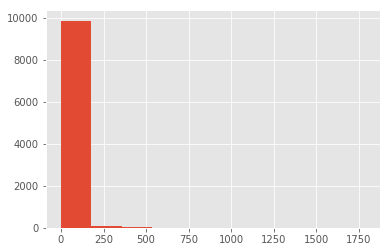

In [71]:
plt.hist(col7)

(array([9.874e+03, 8.600e+01, 1.800e+01, 1.300e+01, 6.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.0000e+00,  1.7780e+02,  3.5660e+02,  5.3540e+02,  7.1420e+02,
         8.9300e+02,  1.0718e+03,  1.2506e+03,  1.4294e+03,  1.6082e+03,
         1.7870e+03]),
 <a list of 10 Patch objects>)

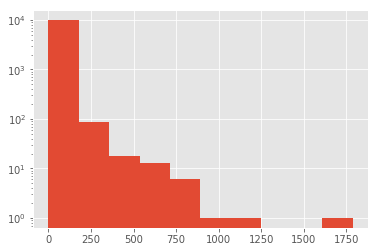

In [72]:
plt.hist(col7, log=True)

(array([ 400., 2152., 1302.,  922.,  598.,  513.,  391.,  309.,  256.,
         455.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 10 Patch objects>)

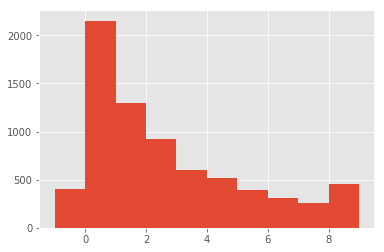

In [73]:
plt.hist(col7[col7<10], bins=10)

In [74]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col7_binary = df[7].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col7_binary)

0.16575840565715896

In [75]:
col0.corr(col7)

0.10657945914852782

In [76]:
df_c[7] = col7

**Summary**: 4% NAs.  Integers ranging from 0 to 1787 with positive skew.  Some positive correlation with target, even better when converted to binary.

## Column 8

In [77]:
col8 = df[8].replace('', '-1').astype(int)
np.sort(col8.unique())

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        57,  72,  94, 122, 357, 393])

In [78]:
col8_notna = df[df[8] != ''][8].astype(int)
col8_notna.describe()

count    9999.000000
mean       12.481648
std        13.973650
min         0.000000
25%         2.000000
50%         7.000000
75%        19.000000
max       393.000000
Name: 8, dtype: float64

(array([9.32e+03, 6.76e+02, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00]),
 array([ -1. ,  38.4,  77.8, 117.2, 156.6, 196. , 235.4, 274.8, 314.2,
        353.6, 393. ]),
 <a list of 10 Patch objects>)

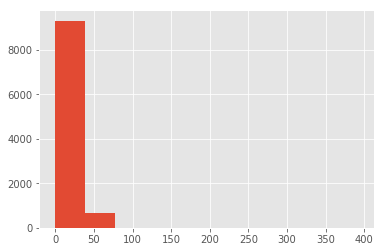

In [79]:
plt.hist(col8)

(array([1.000e+00, 1.127e+03, 8.220e+02, 6.880e+02, 6.300e+02, 5.140e+02,
        4.460e+02, 4.330e+02, 3.620e+02, 3.220e+02, 2.670e+02, 2.660e+02,
        2.830e+02, 2.170e+02, 1.760e+02, 1.940e+02, 1.840e+02, 1.750e+02,
        1.600e+02, 2.780e+02]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19.]),
 <a list of 20 Patch objects>)

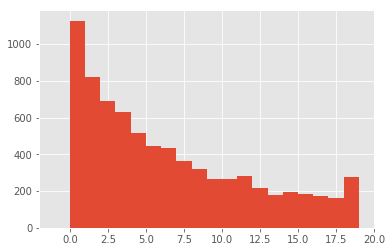

In [80]:
plt.hist(col8[col8<20], bins=20)

In [81]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col8_binary = df[8].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col8_binary)

-0.06123717488368084

In [82]:
col0.corr(col8)

-0.035939006356876316

In [83]:
df_c[8] = col8

**Summary**: only 1 NA.  Integers ranging from 0 to 393 with positive skew.  No correlation to target.

## Column 9

In [84]:
col9 = df[9].replace('', '-1').astype(int)
np.sort(col9.unique())

array([  -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48,   49,   50,   51,   52,   53,
         54,   55,   56,   57,   58,   59,   60,   61,   62,   63,   64,
         65,   66,   67,   68,   69,   70,   71,   72,   73,   74,   75,
         76,   77,   78,   79,   80,   81,   82,   83,   84,   85,   86,
         87,   88,   89,   90,   91,   92,   93,   94,   95,   96,   97,
         98,   99,  100,  101,  102,  103,  104,  105,  106,  107,  108,
        109,  110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
        120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,
        131,  132,  133,  134,  135,  136,  137,  138,  139,  140,  141,
        142,  143,  144,  145,  146,  147,  148,  1

In [85]:
col9_notna = df[df[9] != ''][9].astype(int)
col9_notna.describe()

count    9600.000000
mean      107.797708
std       226.216961
min         0.000000
25%        10.000000
50%        38.000000
75%       109.000000
max      5120.000000
Name: 9, dtype: float64

(array([9.629e+03, 2.730e+02, 4.900e+01, 2.800e+01, 1.300e+01, 4.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([-1.0000e+00,  5.1110e+02,  1.0232e+03,  1.5353e+03,  2.0474e+03,
         2.5595e+03,  3.0716e+03,  3.5837e+03,  4.0958e+03,  4.6079e+03,
         5.1200e+03]),
 <a list of 10 Patch objects>)

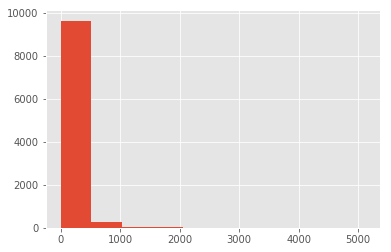

In [86]:
plt.hist(col9)

(array([9.629e+03, 2.730e+02, 4.900e+01, 2.800e+01, 1.300e+01, 4.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([-1.0000e+00,  5.1110e+02,  1.0232e+03,  1.5353e+03,  2.0474e+03,
         2.5595e+03,  3.0716e+03,  3.5837e+03,  4.0958e+03,  4.6079e+03,
         5.1200e+03]),
 <a list of 10 Patch objects>)

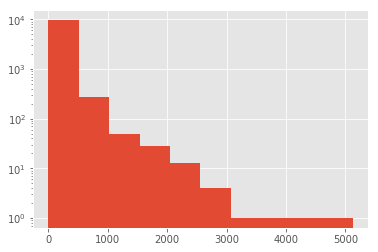

In [87]:
plt.hist(col9, log=True)

(array([400., 324., 364., 281., 282., 232., 185., 184., 153., 167., 147.,
        137., 145., 121.,  95., 123., 113., 113.,  98., 178.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19.]),
 <a list of 20 Patch objects>)

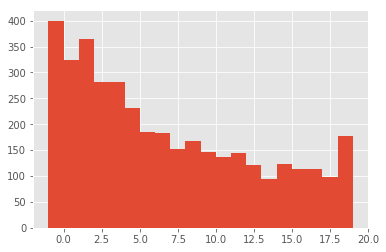

In [88]:
plt.hist(col9[col9<20], bins=20)

In [89]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col9_binary = df[9].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col9_binary)

0.002360141970703166

In [90]:
col0.corr(col9)

0.020734139333987954

**Summary**: 4% NA.  Integers ranging from 0 to 5120 with positive skew.  No correlation to target.

## Column 10

In [91]:
col10 = df[10].replace('', '-1').astype(int)
np.sort(col10.unique())

array([-1,  0,  1,  2,  3,  4,  5])

In [92]:
col10_notna = df[df[10] != ''][10].astype(int)
col10_notna.describe()

count    5477.000000
mean        0.616031
std         0.684471
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: 10, dtype: float64

(array([4.523e+03, 2.628e+03, 0.000e+00, 2.415e+03, 0.000e+00, 3.590e+02,
        6.200e+01, 0.000e+00, 1.000e+01, 3.000e+00]),
 array([-1. , -0.4,  0.2,  0.8,  1.4,  2. ,  2.6,  3.2,  3.8,  4.4,  5. ]),
 <a list of 10 Patch objects>)

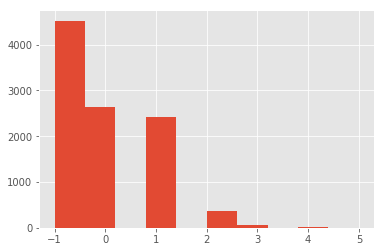

In [93]:
plt.hist(col10)

In [94]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col10_binary = df[10].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col10_binary)

0.18508946336606968

In [95]:
col0.corr(col10)

0.1876528894069429

**Summary**: 45% NAs.  Integers ranging from 0 to 5 with positive skew.  Some positive correlation with target.

## Column 11

In [96]:
col11 = df[11].replace('', '-1').astype(int)
np.sort(col11.unique())

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  49,  50,  51,
        52,  54,  55,  56,  57,  59,  60,  61,  63,  64,  71,  86, 100])

In [97]:
col11_notna = df[df[11] != ''][11].astype(int)
col11_notna.describe()

count    9600.000000
mean        2.712083
std         5.244379
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       100.000000
Name: 11, dtype: float64

(array([9.478e+03, 3.480e+02, 9.400e+01, 4.000e+01, 2.200e+01, 1.000e+01,
        5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([ -1. ,   9.1,  19.2,  29.3,  39.4,  49.5,  59.6,  69.7,  79.8,
         89.9, 100. ]),
 <a list of 10 Patch objects>)

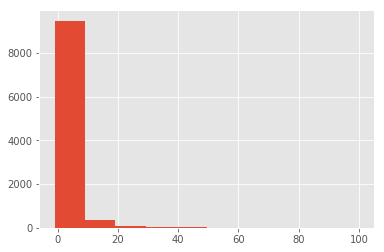

In [98]:
plt.hist(col11)

(array([ 400., 2230., 3393., 1362.,  748.,  457.,  319.,  206.,  152.,
         126.,  156.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 11 Patch objects>)

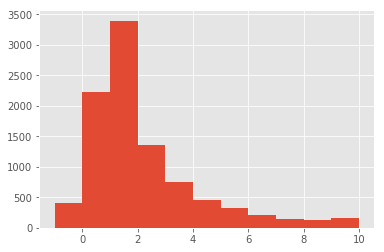

In [99]:
plt.hist(col11[col11<11], bins=11)

In [100]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col11_binary = df[11].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col11_binary)

0.1660141723977016

In [101]:
col0.corr(col10)

0.1876528894069429

**Summary**: 4% NAs.  Integers ranging from 0 to 10 with positive skew.  Some positive correlation with target.

## Column 12

In [102]:
col12 = df[12].replace('', '-1').astype(int)
np.sort(col12.unique())

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 40,
       44, 50, 64, 66])

In [103]:
col12_notna = df[df[12] != ''][12].astype(int)
col12_notna.describe()

count    2407.000000
mean        0.882842
std         3.729361
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        66.000000
Name: 12, dtype: float64

(array([9.93e+03, 3.40e+01, 1.50e+01, 6.00e+00, 5.00e+00, 5.00e+00,
        2.00e+00, 1.00e+00, 0.00e+00, 2.00e+00]),
 array([-1. ,  5.7, 12.4, 19.1, 25.8, 32.5, 39.2, 45.9, 52.6, 59.3, 66. ]),
 <a list of 10 Patch objects>)

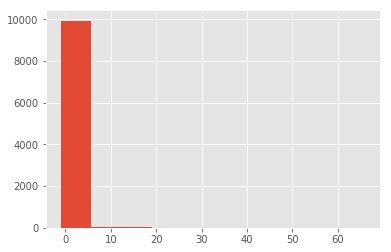

In [104]:
plt.hist(col12)

(array([9.93e+03, 3.40e+01, 1.50e+01, 6.00e+00, 5.00e+00, 5.00e+00,
        2.00e+00, 1.00e+00, 0.00e+00, 2.00e+00]),
 array([-1. ,  5.7, 12.4, 19.1, 25.8, 32.5, 39.2, 45.9, 52.6, 59.3, 66. ]),
 <a list of 10 Patch objects>)

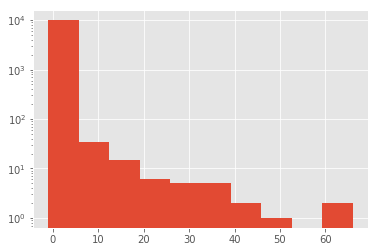

In [105]:
plt.hist(col12, log=True)

(array([7.593e+03, 1.778e+03, 3.790e+02, 8.600e+01, 4.700e+01, 2.500e+01,
        2.200e+01, 1.000e+01, 4.000e+00, 4.000e+00, 9.000e+00]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 11 Patch objects>)

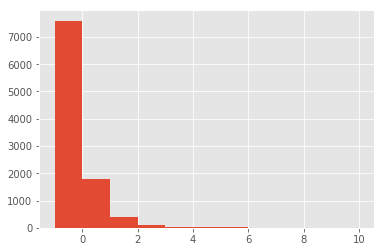

In [106]:
plt.hist(col12[col12<11], bins=11)

In [107]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col12_binary = df[12].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col12_binary)

0.04292844853131348

In [108]:
col0.corr(col12)

0.061045732756099244

**Summary**: 75% NAs.  Integers ranging from 0 to 66 with positive skew.  No correlation with target.

## Column 13

In [109]:
col13 = df[13].replace('', '-1').astype(int)
np.sort(col13.unique())

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  72,  73,  74,  76,  77,  79,  85,
        86,  91,  94,  97, 104, 111, 113, 121, 122, 125, 194, 304, 352,
       387])

In [110]:
col13_notna = df[df[13] != ''][13].astype(int)
col13_notna.describe()

count    7884.000000
mean        8.214485
std        12.622588
min         0.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       387.000000
Name: 13, dtype: float64

(array([9.804e+03, 1.760e+02, 1.300e+01, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([ -1. ,  37.8,  76.6, 115.4, 154.2, 193. , 231.8, 270.6, 309.4,
        348.2, 387. ]),
 <a list of 10 Patch objects>)

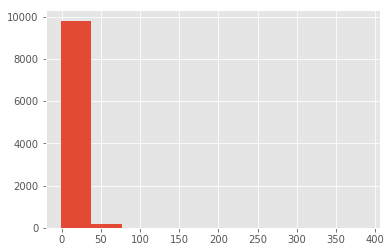

In [111]:
plt.hist(col13)

(array([9.804e+03, 1.760e+02, 1.300e+01, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([ -1. ,  37.8,  76.6, 115.4, 154.2, 193. , 231.8, 270.6, 309.4,
        348.2, 387. ]),
 <a list of 10 Patch objects>)

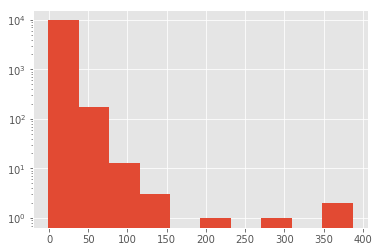

In [112]:
plt.hist(col13, log=True)

(array([2116.,  542., 1235.,  939.,  749.,  567.,  488.,  399.,  315.,
         272.,  234.,  220.,  195.,  157.,  123.,  140.,  121.,  107.,
          79.,   82.,  146.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 21 Patch objects>)

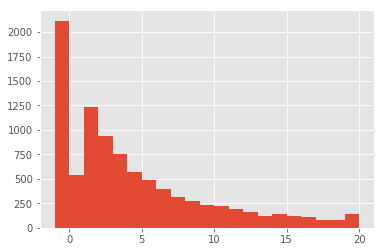

In [113]:
plt.hist(col13[col13<21], bins=21)

In [114]:
#Check correlation to target with any non-zero value, counting blanks as zeroes.
col13_binary = df[13].replace('', '0').replace(regex='^[1-9]\d*$', value='1').astype(int)
col0.corr(col13_binary)

-0.11022988956566139

In [115]:
col0.corr(col13)

-0.10661122971013905

**Summary**: 22% NAs.  Integers ranging from 0 to 387 with positive skew.  Some negative correlation with target.

## Integer Fields

In [116]:
df_i = df.iloc[:,0:14].copy()
df_i.replace('', '-99', inplace=True)
df_i = df_i.astype(int)
df_i.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,22,-1,26,0,0,0,22,6,0,1,1,3,0
1,0,-99,0,14,7,582312,-99,0,7,24,-99,0,-99,7
2,0,0,-1,-99,-99,4438,-99,-99,0,-99,0,-99,-99,-99
3,1,-99,4,8,8,8501,-99,0,29,29,-99,0,-99,8
4,0,9,0,18,1,11,1,117,4,185,1,21,1,1


In [117]:
corr = df_i.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0.147279,0.0422605,0.0133557,-0.0417311,-0.0679078,-0.0477414,0.116107,-0.0354222,0.0250411,0.140741,0.0885897,0.0314593,-0.0564358
1,0.147279,1,0.0250179,0.0339806,0.171792,-0.240847,0.0441739,0.268878,0.262138,0.193615,0.992386,0.213139,0.183342,0.160156
2,0.0422605,0.0250179,1,-0.0120274,-0.00126616,-0.00685807,-0.00849512,0.0134443,-0.0307361,-0.00958717,0.0261139,0.0108256,0.0106259,0.00300989
3,0.0133557,0.0339806,-0.0120274,1,0.062143,-0.00644421,0.0105809,0.00283814,0.0445622,0.0017715,0.0228606,0.00597033,-0.0107266,0.0543534
4,-0.0417311,0.171792,-0.00126616,0.062143,1,-0.0969428,0.0300801,0.10162,0.344753,0.146729,0.169498,0.204019,0.0617546,0.985745
5,-0.0679078,-0.240847,-0.00685807,-0.00644421,-0.0969428,1,-0.0472773,-0.132951,-0.128475,-0.085292,-0.241734,-0.221036,-0.0978237,-0.0953971
6,-0.0477414,0.0441739,-0.00849512,0.0105809,0.0300801,-0.0472773,1,0.0252532,0.0707045,0.225701,0.0517647,0.108363,0.0376442,0.0404948
7,0.116107,0.268878,0.0134443,0.00283814,0.10162,-0.132951,0.0252532,1,0.129537,0.333835,0.217861,0.570198,0.228557,0.0916359
8,-0.0354222,0.262138,-0.0307361,0.0445622,0.344753,-0.128475,0.0707045,0.129537,1,0.24351,0.258134,0.133918,0.105866,0.375974
9,0.0250411,0.193615,-0.00958717,0.0017715,0.146729,-0.085292,0.225701,0.333835,0.24351,1,0.187051,0.275891,0.198845,0.165356


Converting the values to binary, where all nonzero values are converted to 1 and zeroes and blanks are converted to 0, check for correlations.  This should tell us which fields at least tend to have values together.

In [118]:
df_b = df.iloc[:,0:14].copy()
df_b = df_b.replace('', '0').replace(regex='^[1-9]\d*$', value='1')
df_b = df_b.astype(int)
corr_b = df_b.corr()
corr_b.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0.184894,-0.0223243,-0.0562837,-0.0569235,-0.0289084,0.0604534,0.165758,-0.0612372,0.00236014,0.185089,0.166014,0.0429284,-0.11023
1,0.184894,1,0.00784414,0.0409131,0.106612,-0.0499366,0.186653,0.396537,0.0733186,0.0401349,0.923722,0.40478,0.140407,0.0145989
2,-0.0223243,0.00784414,1,0.267366,0.304678,0.0218245,0.043155,-0.00669291,0.172172,0.067835,0.00673514,-0.00329911,-0.00909138,0.299688
3,-0.0562837,0.0409131,0.267366,1,0.447753,0.0160233,0.0783175,0.0234178,0.290273,0.1506,0.0430461,0.0288984,0.0136645,0.43283
4,-0.0569235,0.106612,0.304678,0.447753,1,0.0360711,0.176202,0.0858295,0.559219,0.347924,0.103636,0.0916093,0.0358627,0.889097
5,-0.0289084,-0.0499366,0.0218245,0.0160233,0.0360711,1,0.242814,0.141089,0.0615255,0.0879427,-0.062391,0.136047,-0.0148308,0.134274
6,0.0604534,0.186653,0.043155,0.0783175,0.176202,0.242814,1,0.773572,0.18291,0.378855,0.155043,0.755136,0.0791119,0.237425
7,0.165758,0.396537,-0.00669291,0.0234178,0.0858295,0.141089,0.773572,1,0.0769539,0.251575,0.367949,0.979888,0.130869,0.0434479
8,-0.0612372,0.0733186,0.172172,0.290273,0.559219,0.0615255,0.18291,0.0769539,1,0.418794,0.0625869,0.077785,0.0272788,0.550398
9,0.00236014,0.0401349,0.067835,0.1506,0.347924,0.0879427,0.378855,0.251575,0.418794,1,0.026731,0.245928,0.0342349,0.328054


# Categorical Variables

In [119]:
def cat_eda(col):
    print(df[col].describe())
    top10 = df[col].value_counts()[:10]
    plt.bar(x=np.arange(len(top10)), height=top10.tolist())
    plt.xticks(np.arange(10), top10.index, rotation=90)
    plt.show()
    print("correlation with target variable:")
    size = len(top10) if len(top10) < 10 else 10
    for cat in range(size):
        col_binary = (df[col].where(df[col]==top10.index[cat])==top10.index[cat]).astype('int')
        correlation = col0.corr(col_binary)
        marker = '(!!!)' if correlation > .1 or correlation < -.1 else ''
        print('{:8}: {} {}'.format(top10.index[cat], correlation, marker))
    top5_share = (np.sum(top10[:5])/10000)*100
    top10_share = (np.sum(top10)/10000)*100
    print("\n{:.2f}% of records are in the top 5, {:.2f}% are in the top 10 ".format(top5_share, top10_share))

## Column A

count        10000
unique         182
top       05db9164
freq          4982
Name: a, dtype: object


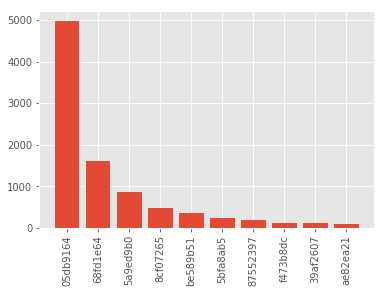

correlation with target variable:
05db9164: 0.007388768573699658 
68fd1e64: 0.0056645789409112525 
5a9ed9b0: -0.0071943377981743785 
8cf07265: -0.013827998046923208 
be589b51: 0.007392746060768605 
5bfa8ab5: 0.0067582360362961145 
87552397: 0.005440488886808017 
f473b8dc: -0.0028287379901573047 
39af2607: 0.0019292943512287822 
ae82ea21: 0.003305814266155385 

83.13% of records are in the top 5, 90.99% are in the top 10 


In [120]:
cat_eda('a')

## Column B

count        10000
unique         392
top       38a947a1
freq          1116
Name: b, dtype: object


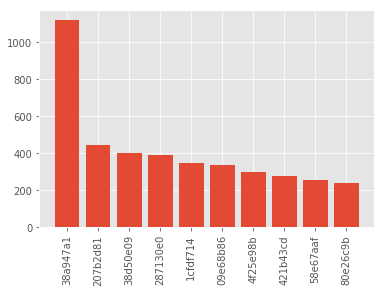

correlation with target variable:
38a947a1: 0.0263689487208438 
207b2d81: -0.03716067687097554 
38d50e09: -0.028020738218061406 
287130e0: 0.014158912899357683 
1cfdf714: 0.0049627969420698165 
09e68b86: -0.011297840108279975 
4f25e98b: -0.0007028958980383849 
421b43cd: 0.01232225563397968 
58e67aaf: 0.006642680991318183 
80e26c9b: -0.01806966065182451 

26.99% of records are in the top 5, 40.98% are in the top 10 


In [121]:
cat_eda('b')

## Column C

count     10000
unique     5937
top            
freq        343
Name: c, dtype: object


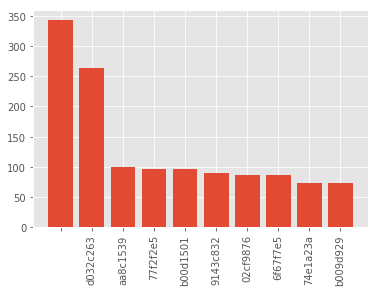

correlation with target variable:
        : 0.022738693264930398 
d032c263: -0.014729421211650485 
aa8c1539: -0.0229233464334598 
77f2f2e5: -0.019129078910086094 
b00d1501: -0.03568818461480046 
9143c832: -0.008178681663569533 
02cf9876: -0.029379197068041096 
6f67f7e5: -0.028921254446253528 
74e1a23a: -0.025242061702558268 
b009d929: 0.018111952192364583 

8.98% of records are in the top 5, 13.06% are in the top 10 


In [122]:
cat_eda('c')

## Column D

count        10000
unique        4264
top       c18be181
freq           351
Name: d, dtype: object


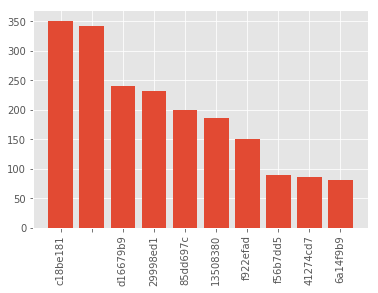

correlation with target variable:
c18be181: -0.027657104143801053 
        : 0.022738693264930398 
d16679b9: -0.038304048047633134 
29998ed1: -0.0018521979714626652 
85dd697c: -0.028305764861401045 
13508380: 0.06484468658974839 
f922efad: 0.007781620951322178 
f56b7dd5: -0.008178681663569533 
41274cd7: -0.028921254446253528 
6a14f9b9: 0.03776970297240837 

13.67% of records are in the top 5, 19.61% are in the top 10 


In [123]:
cat_eda('d')

## Column E

count        10000
unique          57
top       25c83c98
freq          6768
Name: e, dtype: object


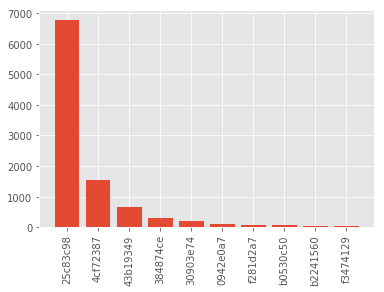

correlation with target variable:
25c83c98: -0.00694963344811008 
4cf72387: 0.009212623150038622 
43b19349: -0.0024169044056187162 
384874ce: 0.0036629943490932306 
30903e74: -0.025958884543471075 
0942e0a7: 0.007961571967150211 
f281d2a7: 0.013098375629418246 
b0530c50: 0.009983074587066558 
b2241560: -0.014749295050337605 
f3474129: -0.010027747147663153 

94.51% of records are in the top 5, 97.87% are in the top 10 


In [124]:
cat_eda('e')

## Column F

count        10000
unique           8
top       7e0ccccf
freq          3905
Name: f, dtype: object


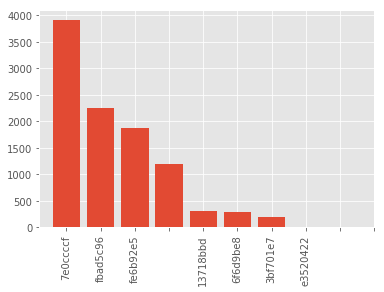

correlation with target variable:
7e0ccccf: -0.028729781655223916 
fbad5c96: 0.0004010356409258775 
fe6b92e5: 0.016167924355019278 
        : 0.007960284242060387 
13718bbd: -0.014966674318238565 
6f6d9be8: 0.03600071474114325 
3bf701e7: 0.012702528904564196 
e3520422: -0.008185380334368343 

95.25% of records are in the top 5, 100.00% are in the top 10 


In [125]:
cat_eda('f')

## Column G

count        10000
unique        3335
top       1c86e0eb
freq           192
Name: g, dtype: object


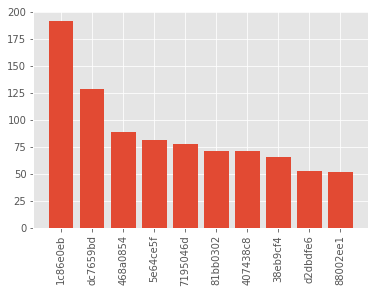

correlation with target variable:
1c86e0eb: 0.058540642925752936 
dc7659bd: -0.010968900612177257 
468a0854: 0.06550092252461748 
5e64ce5f: 0.008763417517692041 
7195046d: 0.008992939135882234 
81bb0302: 0.008753006353176718 
407438c8: 0.011500254196363285 
38eb9cf4: 0.0012551343577738346 
d2dbdfe6: -0.007299432574045383 
88002ee1: -0.03542800538027275 

5.70% of records are in the top 5, 8.83% are in the top 10 


In [126]:
cat_eda('g')

## Column H

count        10000
unique          96
top       0b153874
freq          5910
Name: h, dtype: object


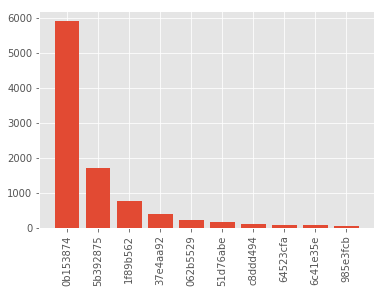

correlation with target variable:
0b153874: -0.01492831886724514 
5b392875: 0.015590059482642454 
1f89b562: 0.011438085472732153 
37e4aa92: -0.000425959043506737 
062b5529: -0.004195654260838399 
51d76abe: 0.0015736059713950736 
c8ddd494: 0.0008411860351377065 
64523cfa: 0.0033058142661553333 
6c41e35e: -0.002139363354713927 
985e3fcb: -0.0009032353626785858 

90.32% of records are in the top 5, 95.48% are in the top 10 


In [127]:
cat_eda('h')

## Column I

count        10000
unique           3
top       a73ee510
freq          9035
Name: i, dtype: object


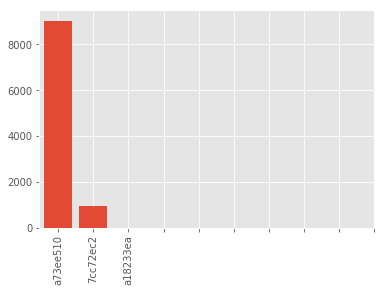

correlation with target variable:
a73ee510: 0.10555209339588997 (!!!)
7cc72ec2: -0.10574531321630398 (!!!)
a18233ea: -4.15278217912994e-05 

100.00% of records are in the top 5, 100.00% are in the top 10 


In [128]:
cat_eda('i')

## Column J

count        10000
unique        3339
top       3b08e48b
freq          2188
Name: j, dtype: object


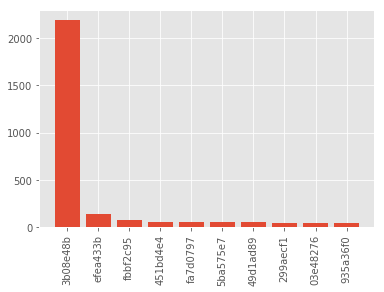

correlation with target variable:
3b08e48b: -0.04350088303067153 
efea433b: 0.010473536829646322 
fbbf2c95: -0.02192977325117835 
451bd4e4: 0.002059163334201181 
fa7d0797: -0.027975185412492793 
5ba575e7: 0.003744192738985046 
49d1ad89: 0.0038991282813932737 
299aecf1: 0.0015632775358342783 
03e48276: -0.011340044972049051 
935a36f0: 0.05362256954037557 

25.29% of records are in the top 5, 27.69% are in the top 10 


In [129]:
cat_eda('j')

## Column K

count        10000
unique        2155
top       755e4a50
freq           297
Name: k, dtype: object


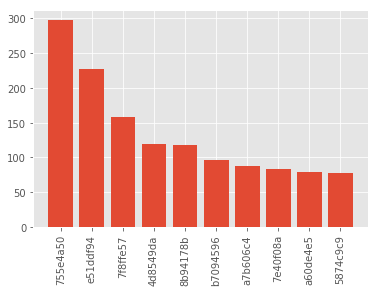

correlation with target variable:
755e4a50: 0.05636578323905547 
e51ddf94: -0.006123821279792053 
7f8ffe57: -0.015985781023735008 
4d8549da: 0.0018896245813541023 
8b94178b: -0.0055670366804869255 
b7094596: 0.011623545970097777 
a7b606c4: -0.005135160883981473 
7e40f08a: -0.009724067029571693 
a60de4e5: 0.06299775011240336 
5874c9c9: 0.012351614234894913 

9.20% of records are in the top 5, 13.43% are in the top 10 


In [130]:
cat_eda('k')

## Column L

count     10000
unique     5564
top            
freq        343
Name: l, dtype: object


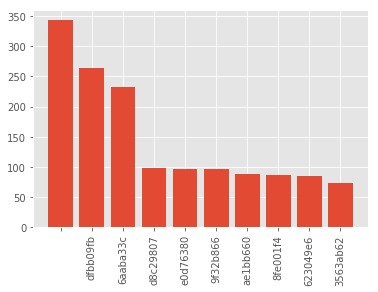

correlation with target variable:
        : 0.022738693264930398 
dfbb09fb: -0.014729421211650485 
6aaba33c: -0.0018521979714626652 
d8c29807: -0.0229233464334598 
e0d76380: -0.03568818461480046 
9f32b866: -0.019129078910086094 
ae1bb660: -0.008178681663569533 
8fe001f4: -0.029379197068041096 
623049e6: -0.028921254446253528 
3563ab62: 0.018111952192364583 

10.34% of records are in the top 5, 14.65% are in the top 10 


In [131]:
cat_eda('l')

## Column M

count        10000
unique        1780
top       5978055e
freq           297
Name: m, dtype: object


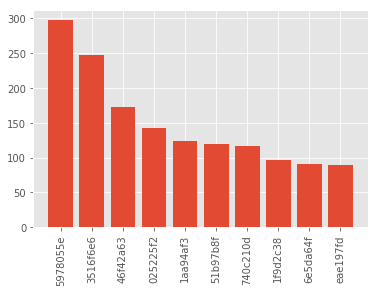

correlation with target variable:
5978055e: 0.05636578323905547 
3516f6e6: -0.005903427341159826 
46f42a63: -0.020177538541014395 
025225f2: -0.010971849627691634 
1aa94af3: -0.006485779062917329 
51b97b8f: 0.0018896245813541023 
740c210d: 0.0040834863467948375 
1f9d2c38: 0.011623545970097777 
6e5da64f: -0.028740786655566945 
eae197fd: -0.003266708051023711 

9.83% of records are in the top 5, 14.95% are in the top 10 


In [132]:
cat_eda('m')

## Column N

count        10000
unique          23
top       b28479f6
freq          3487
Name: n, dtype: object


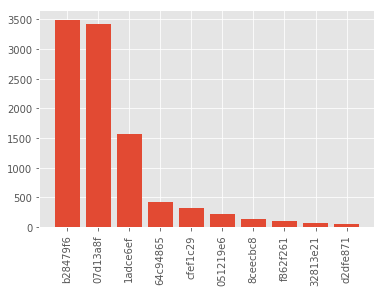

correlation with target variable:
b28479f6: -0.07254892673135831 
07d13a8f: 0.05379249690827965 
1adce6ef: -0.009760718627566197 
64c94865: 0.07094731037844995 
cfef1c29: -0.007287630375371806 
051219e6: 0.011848043297804669 
8ceecbc8: -0.05160330696695822 
f862f261: -0.011375159989787718 
32813e21: 0.039123017662843075 
d2dfe871: 0.011332682733746045 

92.31% of records are in the top 5, 98.26% are in the top 10 


In [133]:
cat_eda('n')

## Column O

count        10000
unique        2137
top       2d0bb053
freq           144
Name: o, dtype: object


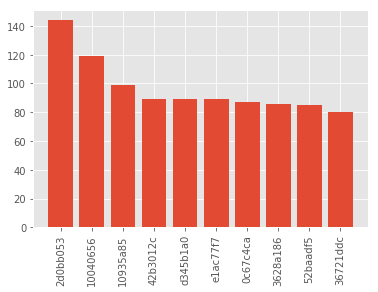

correlation with target variable:
2d0bb053: -0.02154903037556745 
10040656: 0.019448665646952634 
10935a85: 0.007364332687087733 
42b3012c: -0.02782657611375274 
d345b1a0: -0.0032667080510237847 
e1ac77f7: 0.023749146817978146 
0c67c4ca: -0.026895391528103763 
3628a186: -0.021427018837329226 
52baadf5: -0.025946399342520663 
36721ddc: 0.01017069007068943 

5.40% of records are in the top 5, 9.67% are in the top 10 


In [134]:
cat_eda('o')

## Column P

count     10000
unique     5029
top            
freq        343
Name: p, dtype: object


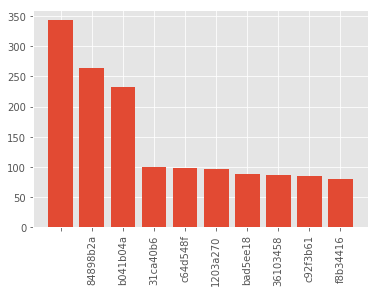

correlation with target variable:
        : 0.022738693264930398 
84898b2a: -0.014729421211650485 
b041b04a: -0.0018521979714626652 
31ca40b6: -0.021072984937448504 
c64d548f: -0.0229233464334598 
1203a270: -0.03568818461480046 
bad5ee18: -0.008178681663569533 
36103458: -0.029379197068041096 
c92f3b61: -0.028921254446253528 
f8b34416: 0.03865276511589968 

10.38% of records are in the top 5, 14.76% are in the top 10 


In [135]:
cat_eda('p')

## Column Q

count        10000
unique           9
top       e5ba7672
freq          4571
Name: q, dtype: object


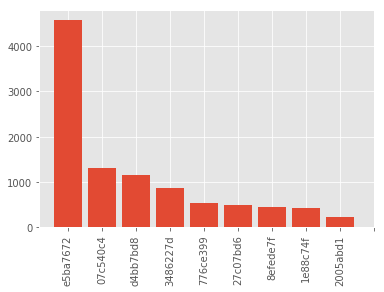

correlation with target variable:
e5ba7672: 0.11119152647257989 (!!!)
07c540c4: -0.020172624801398323 
d4bb7bd8: -0.05389505154687326 
3486227d: -0.013427198772025651 
776ce399: -0.08658388326439642 
27c07bd6: 0.015022627659508271 
8efede7f: 0.03796245079432282 
1e88c74f: -0.05445116857428431 
2005abd1: -0.054531048562458266 

84.27% of records are in the top 5, 100.00% are in the top 10 


In [136]:
cat_eda('q')

## Column R

count        10000
unique        1225
top       e88ffc9d
freq           302
Name: r, dtype: object


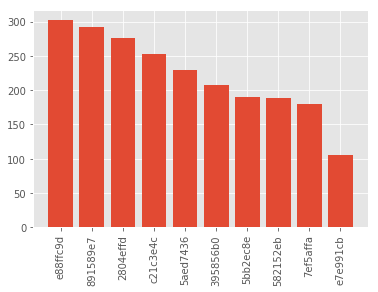

correlation with target variable:
e88ffc9d: 0.003003235433686488 
891589e7: 0.014710062026110955 
2804effd: 0.01232225563397968 
c21c3e4c: 0.006642680991318183 
5aed7436: -0.008413464072214499 
395856b0: -0.019337772488618666 
5bb2ec8e: 0.01914079815096204 
582152eb: -0.024063977168911333 
7ef5affa: 0.0014538908153450695 
e7e991cb: 0.019587065819601502 

13.52% of records are in the top 5, 22.22% are in the top 10 


In [137]:
cat_eda('r')

## Column S

count     10000
unique      516
top            
freq       4351
Name: s, dtype: object


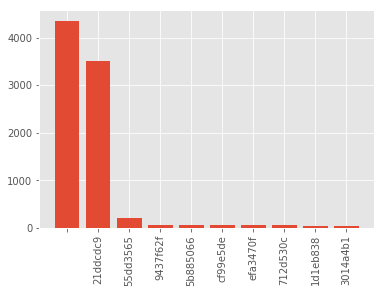

correlation with target variable:
        : 0.016904948378534557 
21ddcdc9: -0.03414129837933251 
55dd3565: 0.01570718827521345 
9437f62f: 0.005441767343295 
5b885066: 0.009018867158338412 
cf99e5de: -0.026199748954581846 
efa3470f: 0.002935255465802938 
712d530c: 0.04117052582338273 
1d1eb838: 0.029103911244025664 
3014a4b1: -0.0011249495287423625 

82.12% of records are in the top 5, 84.60% are in the top 10 


In [138]:
cat_eda('s')

## Column T

count     10000
unique        4
top            
freq       4351
Name: t, dtype: object


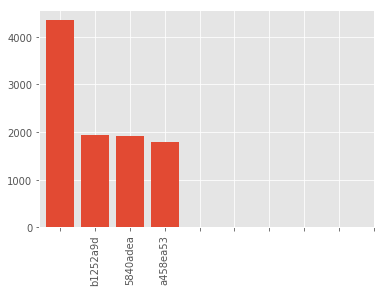

correlation with target variable:
        : 0.016904948378534557 
b1252a9d: 0.024907172956562855 
5840adea: -0.040834823674224044 
a458ea53: -0.005637380127585398 

100.00% of records are in the top 5, 100.00% are in the top 10 


In [139]:
cat_eda('t')

## Column U

count     10000
unique     5325
top            
freq        343
Name: u, dtype: object


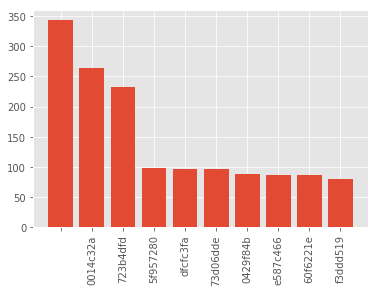

correlation with target variable:
        : 0.022738693264930398 
0014c32a: -0.014729421211650485 
723b4dfd: -0.0018521979714626652 
5f957280: -0.0229233464334598 
dfcfc3fa: -0.019129078910086094 
73d06dde: -0.03568818461480046 
0429f84b: -0.008178681663569533 
e587c466: -0.029379197068041096 
60f6221e: -0.028921254446253528 
f3ddd519: 0.03865276511589968 

10.34% of records are in the top 5, 14.72% are in the top 10 


In [140]:
cat_eda('u')

## Column V

count     10000
unique        9
top            
freq       7608
Name: v, dtype: object


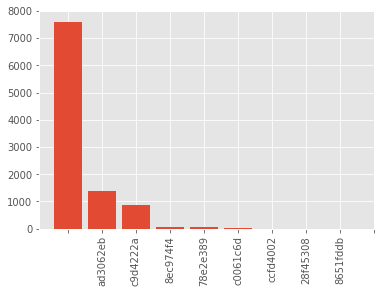

correlation with target variable:
        : -0.027493559733005057 
ad3062eb: 0.032472905529789806 
c9d4222a: 0.007801042292814414 
8ec974f4: -0.002351764920914792 
78e2e389: -0.011850112712847352 
c0061c6d: -0.01721289416574604 
ccfd4002: 0.01661327368861579 
28f45308: 0.017279902340783755 
8651fddb: -0.0057876485079464725 

99.62% of records are in the top 5, 100.00% are in the top 10 


In [141]:
cat_eda('v')

## Column W

count        10000
unique          13
top       32c7478e
freq          4417
Name: w, dtype: object


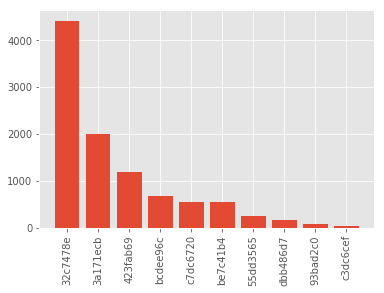

correlation with target variable:
32c7478e: 0.042164512121785076 
3a171ecb: -0.06700585833873288 
423fab69: 0.08361670757761878 
bcdee96c: -0.001248082524840807 
c7dc6720: -0.003010451997378051 
be7c41b4: -0.07894287367630262 
55dd3565: -0.0060968777180676545 
dbb486d7: -0.0007237331844295828 
93bad2c0: -0.021929773251178317 
c3dc6cef: 0.024308073557775235 

88.44% of records are in the top 5, 99.59% are in the top 10 


In [142]:
cat_eda('w')

## Column X

count        10000
unique        2730
top       3fdb382b
freq           526
Name: x, dtype: object


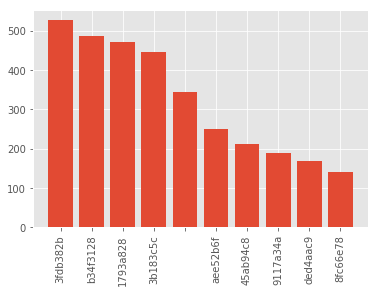

correlation with target variable:
3fdb382b: 0.011393622576037809 
b34f3128: 0.014801430095929624 
1793a828: -0.015689810477334035 
3b183c5c: -0.013298962911023601 
        : 0.022738693264930398 
aee52b6f: -0.03682849924067358 
45ab94c8: 0.06000274259736022 
9117a34a: -0.02103862358345674 
ded4aac9: 0.027912819175660495 
8fc66e78: -0.0168205913887838 

22.74% of records are in the top 5, 32.38% are in the top 10 


In [143]:
cat_eda('x')

## Column Y

count     10000
unique       38
top            
freq       4351
Name: y, dtype: object


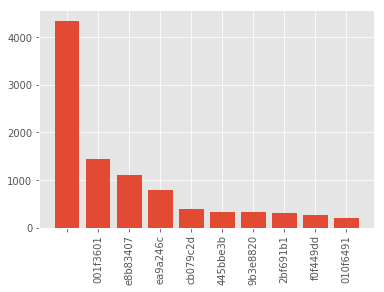

correlation with target variable:
        : 0.016904948378534557 
001f3601: -0.03138476688734895 
e8b83407: -0.029866101305456652 
ea9a246c: -0.01883043638909493 
cb079c2d: 0.003146349727272038 
445bbe3b: 0.007577281718448276 
9b3e8820: 0.008627699054064856 
2bf691b1: 0.03015890924906618 
f0f449dd: 0.016794780314060013 
010f6491: -0.011829766688292258 

80.85% of records are in the top 5, 95.22% are in the top 10 


In [144]:
cat_eda('y')

## Column Z

count     10000
unique     2010
top            
freq       4351
Name: z, dtype: object


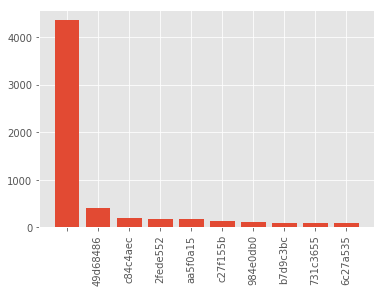

correlation with target variable:
        : 0.016904948378534557 
49d68486: 0.013563737168837782 
c84c4aec: 0.06484468658974839 
2fede552: 0.01697303611563134 
aa5f0a15: -0.028252593190399522 
c27f155b: -0.007634749735085201 
984e0db0: -0.03049219796308151 
b7d9c3bc: -0.016073615661711962 
731c3655: -0.028921254446253528 
6c27a535: -0.006583177866743157 

52.85% of records are in the top 5, 57.93% are in the top 10 


In [145]:
cat_eda('z')

## Cyclicality Check
It may be that one or more of the fields is a timestamp, or mirrors the daily pattern that the timestamp does, so that adding another column is not necessary.  We should check for other chronological patterns in the data.

First 12m records in Column 1:


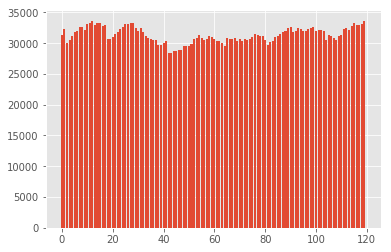

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 2:


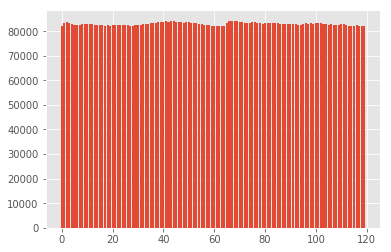

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 3:


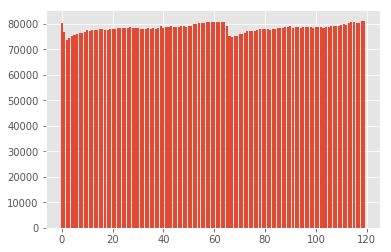

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 4:


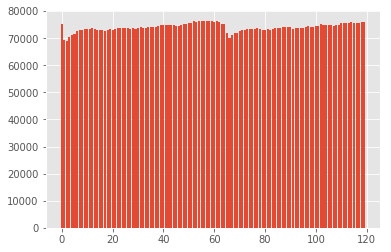

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 5:


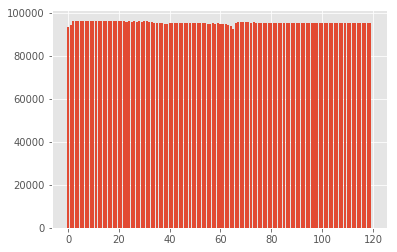

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 6:


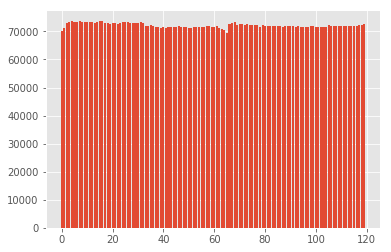

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 7:


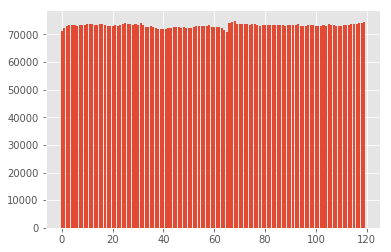

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 8:


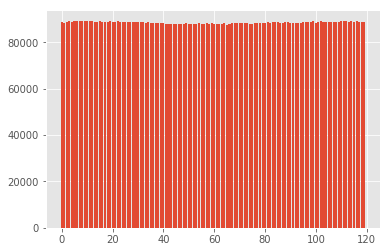

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 9:


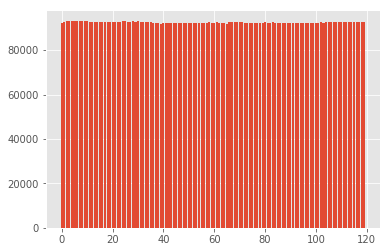

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 10:


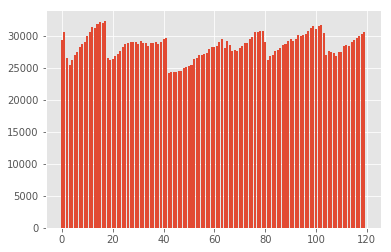

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 11:


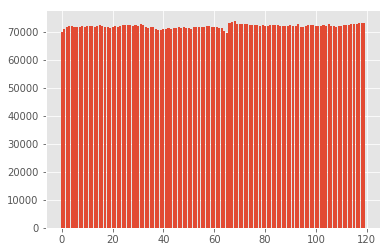

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 12:


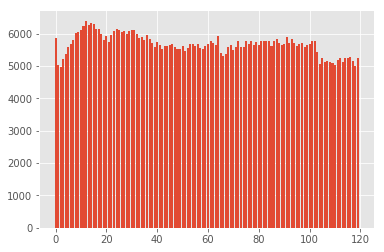

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column 13:


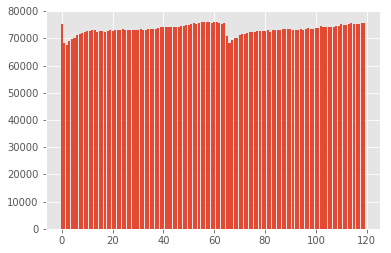

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column a:


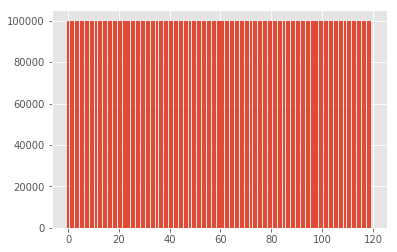

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column b:


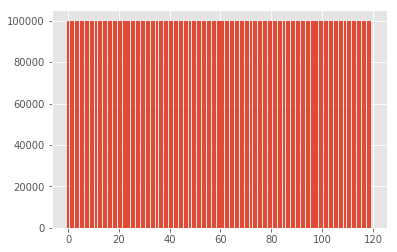

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column c:


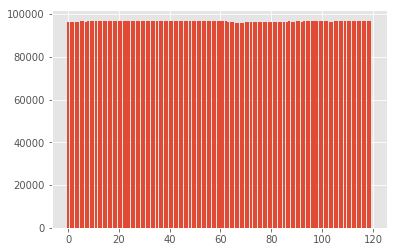

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column d:


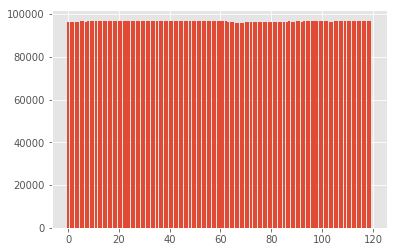

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column e:


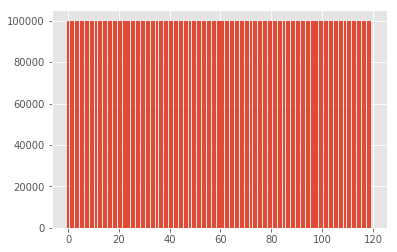

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column f:


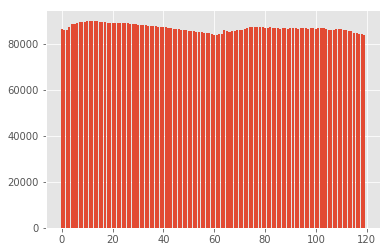

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column g:


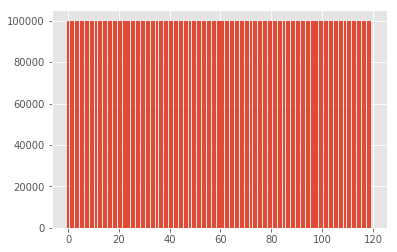

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column h:


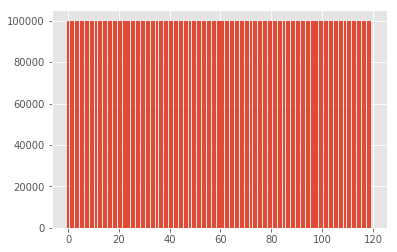

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column i:


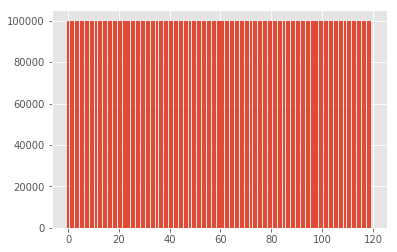

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column j:


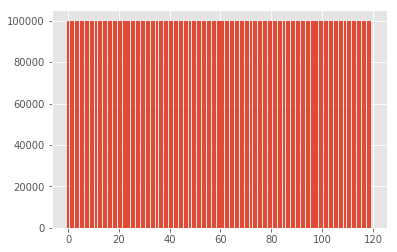

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column k:


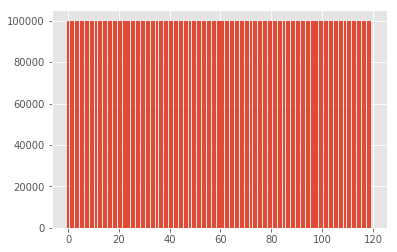

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column l:


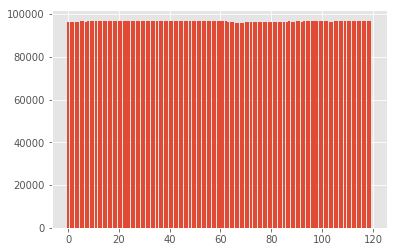

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column m:


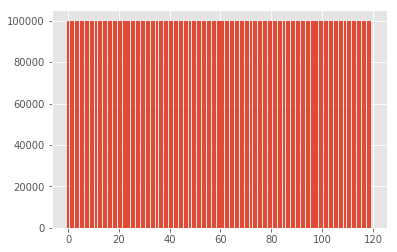

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column n:


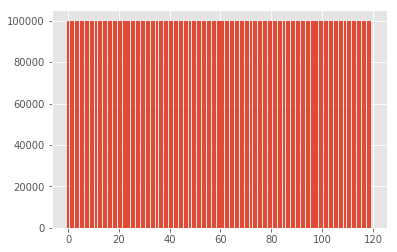

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column o:


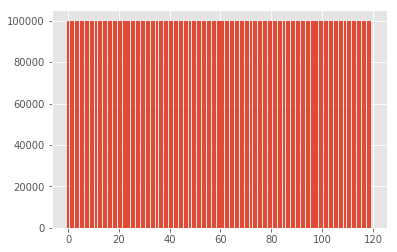

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column p:


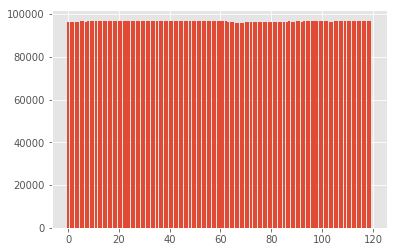

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column q:


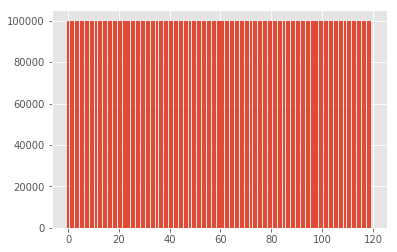

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column r:


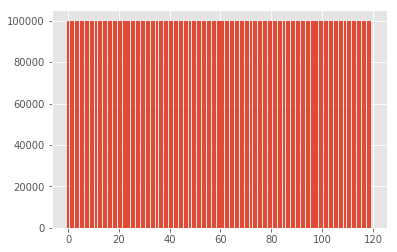

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column s:


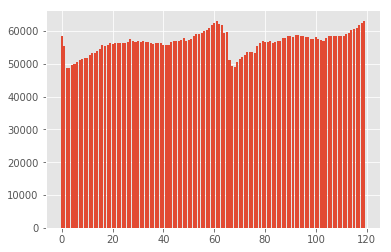

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column t:


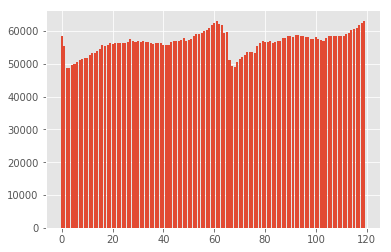

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column u:


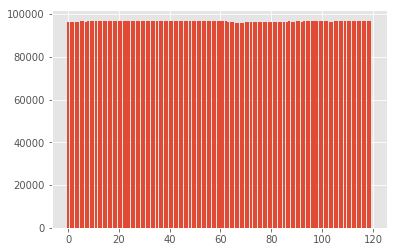

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column v:


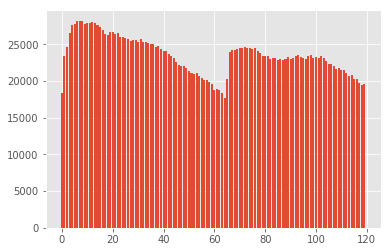

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column w:


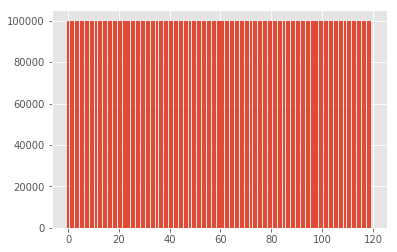

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column x:


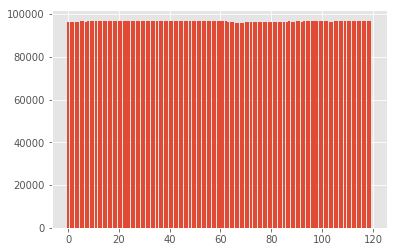

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column y:


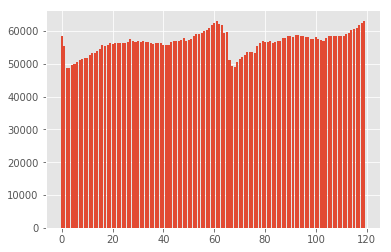

<Figure size 1440x1280 with 0 Axes>

First 12m records in Column z:


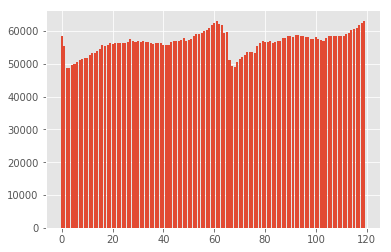

<Figure size 1440x1280 with 0 Axes>

In [157]:
column_names=[x for x in range(14)]+list(map(chr, range(97, 123)))
for i in range(1, len(column_names)):
    binarize = train_RDD.map(lambda x: x.split('\t')) \
                        .flatMap(lambda x: '0' if x[i] == '0' or x[i] == '' else '1')

    binary_list = binarize.take(12000000)
    binary_list = list(map(int, binary_list))
    
    print(f'First 12m records in Column {column_names[i]}:')

    bingroup = binplot(binary_list, 120)
    plt.bar(x=np.arange(len(bingroup)), height=bingroup)
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.show()

Some of the columns clearly have cyclicality in terms of binary value, and those patterns don't align with the daily pattern of clicks.  It's not clear whether this information has any value, though - to the extent that these patterns exist, the addition of a daypart column should capture it.

Categorical columns that show clear seasonality:
[C19, C20, C22, C25, C26]